In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Yelp EDA').getOrCreate()
sc = spark.sparkContext 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from pyspark.sql import functions as F 
from pyspark.sql import * 
from pyspark.sql.functions import *
from pyspark.sql.types import *
from ast import literal_eval 

## Read Data

In [4]:
df_review = spark.read.option('multiline','true').option("quote", "\"").option('escape','\"').option('ignoreLeadingWhiteSpace', 'true').option('header', True).option('escapeQuotes', 'true').\
parquet("gs://msca-bdp-student-gcs/GroupProject_Gr7/yelp_dataset/engineered_data/review.snappy.parquet")

df_business = spark.read.option('multiline','true').option("quote", "\"").option('escape','\"').option('ignoreLeadingWhiteSpace', 'true').option('header', True).option('escapeQuotes', 'true').\
parquet("gs://msca-bdp-student-gcs/GroupProject_Gr7/yelp_dataset/engineered_data/business.snappy.parquet")

df_user = spark.read.option('multiline','true').option("quote", "\"").option('escape','\"').option('ignoreLeadingWhiteSpace', 'true').option('header', True).option('escapeQuotes', 'true').\
parquet("gs://msca-bdp-student-gcs/GroupProject_Gr7/yelp_dataset/engineered_data/user.snappy.parquet")

df_sentiment = spark.read.option('multiline','true').option("quote", "\"").option('escape','\"').option('ignoreLeadingWhiteSpace', 'true').option('header', True).option('escapeQuotes', 'true').\
parquet("gs://msca-bdp-student-gcs/GroupProject_Gr7/yelp_dataset/engineered_data/aspect_sentiment.snappy.parquet")

df_checkin = spark.read.option('multiline','true').option("quote", "\"").option('escape','\"').option('ignoreLeadingWhiteSpace', 'true').option('header', True).option('escapeQuotes', 'true').\
parquet("gs://msca-bdp-student-gcs/GroupProject_Gr7/yelp_dataset/engineered_data/checkin.snappy.parquet")


## Data Cleansing

#### Data Cleansing df_business

In [5]:
df_business.printSchema()

root
 |-- address: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- city: string (nullable = true)
 |-- is_open: long (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- stars: double (nullable = true)
 |-- state: string (nullable = true)
 |-- AcceptsInsurance: string (nullable = true)
 |-- AgesAllowed: string (nullable = true)
 |-- Alcohol: string (nullable = true)
 |-- Ambience: string (nullable = true)
 |-- BYOB: string (nullable = true)
 |-- BYOBCorkage: string (nullable = true)
 |-- BestNights: string (nullable = true)
 |-- BikeParking: string (nullable = true)
 |-- BusinessAcceptsBitcoin: string (nullable = true)
 |-- BusinessAcceptsCreditCards: string (nullable = true)
 |-- BusinessParking: string (nullable = true)
 |-- ByAppointmentOnly: strin

In [6]:
# drop any unnecessary fields 
df_business = df_business.drop('AcceptsInsurance', 'HairSpecializesIn')


# convert different string types to same value     
df_business = df_business.withColumn('AgesAllowed', F.when(col('AgesAllowed') == u'allages', 'allages').when(col('AgesAllowed') == u'21plus', '21plus').otherwise(col('AgesAllowed'))) 
df_business = df_business.withColumn('Alcohol', F.when(col('Alcohol') == u'none', 'none').when(col('Alcohol') == u'full_bar', 'full_bar').when(col('Alcohol') == u'beer_and_wine', 'beer_and_wine').otherwise(col('Alcohol'))) 
df_business = df_business.withColumn('BYOBCorkage', F.when(col('BYOBCorkage') == u'no', 'no').when(col('BYOBCorkage') == u'yes', 'yes').when(col('BYOBCorkage') == u'yes_corkage', 'yes_corkage').otherwise(col('BYOBCorkage'))) 
df_business = df_business.withColumn('NoiseLevel', F.when(col('NoiseLevel') == u'average', 'average').when(col('NoiseLevel') == u'quiet', 'quiet').when(col('NoiseLevel') == u'loud', 'loud').when(col('NoiseLevel') == u'very_loud', 'very_loud').otherwise(col('NoiseLevel'))) 
df_business = df_business.withColumn('RestaurantsAttire', F.when(col('RestaurantsAttire') == u'casual', 'casual').when(col('RestaurantsAttire') == u'dressy', 'dressy').when(col('RestaurantsAttire') == u'formal', 'formal').otherwise(col('RestaurantsAttire'))) 
df_business = df_business.withColumn('Smoking', F.when(col('Smoking') == u'no', 'no').when(col('Smoking') == u'outdoor', 'outdoor').when(col('Smoking') == u'yes', 'yes').otherwise(col('Smoking'))) 
df_business = df_business.withColumn('WiFi', F.when(col('WiFi') == u'no', 'no').when(col('WiFi') == u'free', 'free').when(col('WiFi') == u'paid', 'paid').otherwise(col('WiFi'))) 

# convert any None or null to unknown 
df_business = df_business.replace('None', None) 
df_business = df_business.na.fill('unknown') 


# create open/close for each time 
df_businessHoursCols = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] 
for column in df_businessHoursCols: 
    df_business = df_business.select('*', F.when(col(column) != 'unknown', regexp_extract(column, r'.*?(?=\:)', 0)).otherwise(None).alias('{}_start_str'.format(column)))
    df_business = df_business.select('*', F.when(col(column) != 'unknown', regexp_extract(column, r'(?<=\-).+(?=\:)', 0)).otherwise(None).alias('{}_end_str'.format(column)))
    df_business = df_business.withColumn('{}_start'.format(column), col('{}_start_str'.format(column)).cast(IntegerType())) 
    df_business = df_business.withColumn('{}_end'.format(column), col('{}_end_str'.format(column)).cast(IntegerType()))
    df_business = df_business.drop(column, '{}_start_str'.format(column), '{}_end_str'.format(column)) 



##### Columns that might be impactful to user ratings are nested. Need to unnest them.

**Ambiance**

In [7]:
df_business = df_business.withColumn('Ambience_touristy', when(df_business.Ambience.contains('\'touristy\': True'),1).otherwise(0))\
            .withColumn('Ambience_hipster', when(df_business.Ambience.contains('\'hipster\': True'),1).otherwise(0))\
            .withColumn('Ambience_romantic', when(df_business.Ambience.contains('\'romantic\': True'),1).otherwise(0))\
            .withColumn('Ambience_divey', when(df_business.Ambience.contains('\'divey\': True'),1).otherwise(0))\
            .withColumn('Ambience_intimate', when(df_business.Ambience.contains('\'intimate\': True'),1).otherwise(0))\
            .withColumn('Ambience_trendy', when(df_business.Ambience.contains('\'trendy\': True'),1).otherwise(0))\
            .withColumn('Ambience_upscale', when(df_business.Ambience.contains('\'upscale\': True'),1).otherwise(0))\
            .withColumn('Ambience_classy', when(df_business.Ambience.contains('\'classy\': True'),1).otherwise(0))\
            .withColumn('Ambience_casual', when(df_business.Ambience.contains('\'casual\': True'),1).otherwise(0)) \
            .drop('Ambience')

**Parking**

In [8]:
df_business = df_business.withColumn('Parking_garage', when(df_business.BusinessParking.contains('\'garage\': True'),1).otherwise(0))\
            .withColumn('Parking_street', when(df_business.BusinessParking.contains('\'street\': True'),1).otherwise(0))\
            .withColumn('Parking_validated', when(df_business.BusinessParking.contains('\'validated\': True'),1).otherwise(0))\
            .withColumn('Parking_lot', when(df_business.BusinessParking.contains('\'lot\': True'),1).otherwise(0))\
            .withColumn('Parking_valet', when(df_business.BusinessParking.contains('\'valet\': True'),1).otherwise(0)) \
            .drop('BusinessParking')

**Good For Meal**

In [9]:
df_business = df_business.withColumn('GoodForMeal_breakfast', when(df_business.GoodForMeal.contains('\'breakfast\': True'),1).otherwise(0))\
            .withColumn('GoodForMeal_brunch', when(df_business.GoodForMeal.contains('\'brunch\': True'),1).otherwise(0))\
            .withColumn('GoodForMeal_lunch', when(df_business.GoodForMeal.contains('\'lunch\': True'),1).otherwise(0))\
            .withColumn('GoodForMeal_dinner', when(df_business.GoodForMeal.contains('\'dinner\': True'),1).otherwise(0))\
            .withColumn('GoodForMeal_latenight', when(df_business.GoodForMeal.contains('\'latenight\': True'),1).otherwise(0)) \
            .withColumn('GoodForMeal_dessert', when(df_business.GoodForMeal.contains('\'dessert\': True'),1).otherwise(0)) \
            .drop('GoodForMeal')

##### Some useful columns need to be created from exisiting ones.

**Happy Hour**

In [10]:
df_business = df_business.withColumn('Has_HappyHour', when(df_business.HappyHour == 'True',1).otherwise(0))
df_business = df_business.drop('HappyHour')

**Delivery**

In [11]:
df_business = df_business.withColumn('Has_delivery', when(df_business.RestaurantsDelivery == 'True',1).otherwise(0))
df_business = df_business.drop('RestaurantsDelivery')

**Good for Groups**

In [12]:
df_business = df_business.withColumn('Is_GoodForGroups', when(df_business.RestaurantsGoodForGroups == 'True',1).otherwise(0))
df_business = df_business.drop('RestaurantsGoodForGroups')

**WiFi**

In [13]:
df_business = df_business.withColumn('Has_Free_Wifi', when(df_business.WiFi.isin(["'free'", "u'free'"]),1).otherwise(0))                   
df_business = df_business.drop('WiFi')

#### Data Cleansing df_user

In [14]:
#clean up elite column
df_user = df_user.withColumn('elite', regexp_replace('elite', '20,20', '2020'))

In [15]:
#count of the years someone has been yelp elite
df_user = df_user.withColumn('years_elite', size(split(col('elite'), r",")))

#### Data Cleansing df_reviews

In [16]:
#split date into year and month to get which year and month the review was posted
df_review = df_review.withColumn("review_year", year(to_timestamp("date"))) \
        .withColumn("review_month", month(to_timestamp("date")))

In [17]:
df_review = df_review.withColumn('text_length', length(col('text'))) 

#### Columns with the same name exist in different tables. Need to distinguish them.

1. Columns "useful", "funny", "cool" appear in df_user and df_reviews.<br>
2. Column "review_count" appears in df_user and df_business.<br>
3. Column "stars" appears in df_review and df_business

In [18]:
df_review = df_review.withColumnRenamed('useful', 'useful_review') \
                        .withColumnRenamed('funny', 'funny_review') \
                        .withColumnRenamed('cool', 'cool_review') \
                        .withColumnRenamed('stars', 'stars_review') \
                        .withColumnRenamed('date', 'review_date') \
                        .withColumnRenamed('business_id', 'business_id_r') \
                        .withColumnRenamed('user_id', 'user_id_r') \
                        .withColumnRenamed('review_id', 'review_id_r')

In [19]:
df_user = df_user.withColumnRenamed('useful', 'useful_user') \
                    .withColumnRenamed('funny', 'funny_user') \
                    .withColumnRenamed('cool', 'cool_user') \
                    .withColumnRenamed('review_count', 'review_count_user') \
                    .withColumnRenamed('user_id', 'user_id_u')

In [20]:
df_business = df_business.withColumnRenamed('review_count', 'review_count_business') \
                        .withColumnRenamed('stars', 'stars_business') \
                        .withColumnRenamed('business_id', 'business_id_b')

In [21]:
df_user = df_user.withColumn('is_elite', when((col('elite').isNull()) | (col('elite') == ''), 0).otherwise(1))

In [22]:
df_checkin = df_checkin.withColumnRenamed('date', 'checkin_date') \
                    .withColumnRenamed('business_id', 'business_id_c')

In [23]:
df_sentiment = df_sentiment.withColumnRenamed('review_id', 'review_id_s')

#### Final Table Creation

In [24]:
df_final = df_review.join(df_business, df_review.business_id_r == df_business.business_id_b, "left") \
                    .join(df_user, df_review.user_id_r == df_user.user_id_u, "left") \
                    .join(df_checkin, df_review.business_id_r == df_checkin.business_id_c, "left") \
                    .join(df_sentiment, df_review.review_id_r == df_sentiment.review_id_s, "left")

In [25]:
df_final.printSchema()

root
 |-- business_id_r: string (nullable = true)
 |-- cool_review: long (nullable = true)
 |-- review_date: string (nullable = true)
 |-- funny_review: long (nullable = true)
 |-- review_id_r: string (nullable = true)
 |-- stars_review: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful_review: long (nullable = true)
 |-- user_id_r: string (nullable = true)
 |-- review_year: integer (nullable = true)
 |-- review_month: integer (nullable = true)
 |-- text_length: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- business_id_b: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- city: string (nullable = true)
 |-- is_open: long (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- review_count_business: long (nullable = true)
 |-- stars_business: double (nullable = true)
 |-- state: string (nullable

Can't run queries using df_final because volume is too large and kernel gets killed.

## Exploratory Data Analysis (EDA)

**df_business Summary Stats**

In [29]:
summary_stats_business = df_business.describe(["business_id_b", "review_count_business", "stars_business"])
summary_stats_business.show()

+-------+--------------------+---------------------+------------------+
|summary|       business_id_b|review_count_business|    stars_business|
+-------+--------------------+---------------------+------------------+
|  count|               34987|                34987|             34987|
|   mean|                null|   104.14276731357361| 3.523894589418927|
| stddev|                null|   220.59068270489553|0.8626610441837331|
|    min|---kPU91CF4Lq2-Wl...|                    5|               1.0|
|    max|zznZqH9CiAznbkV6f...|                 7568|               5.0|
+-------+--------------------+---------------------+------------------+



**df_review Summary Stats**

In [30]:
summary_stats_review = df_review.describe(["business_id_r", "stars_review", "user_id_r", "cool_review", "funny_review", "useful_review"])
summary_stats_review.show()

+-------+--------------------+------------------+--------------------+-------------------+------------------+------------------+
|summary|       business_id_r|      stars_review|           user_id_r|        cool_review|      funny_review|     useful_review|
+-------+--------------------+------------------+--------------------+-------------------+------------------+------------------+
|  count|             3773770|           3773770|             3773770|            3773770|           3773770|           3773770|
|   mean|                null| 3.831685820810489|                null|0.48053378981760947|0.2910243602551295|0.9551040471464874|
| stddev|                null|1.3864100588435717|                null|  2.256767539775126|1.7033869382620919| 2.773381459998269|
|    min|---kPU91CF4Lq2-Wl...|               1.0|---2PmXbF47D870st...|                 -1|                -1|                -1|
|    max|zznZqH9CiAznbkV6f...|               5.0|zzzUFM4HFe0SFG0bP...|                404|       

**df_user Summary Stats**

In [31]:
summary_stats_user = df_user.describe(["user_id_u", "average_stars", "review_count_user", "elite", "fans", "friends", "yelping_since", "years_elite"])
summary_stats_user.show()

+-------+--------------------+------------------+-----------------+------------------+------------------+--------------------+-------------------+------------------+
|summary|           user_id_u|     average_stars|review_count_user|             elite|              fans|             friends|      yelping_since|       years_elite|
+-------+--------------------+------------------+-----------------+------------------+------------------+--------------------+-------------------+------------------+
|  count|             1277283|           1277283|          1277283|           1277283|           1277283|             1277283|            1277283|           1277283|
|   mean|                null| 3.706947865116878|29.90745198988791|2017.4579624920534| 1.951187011805528|                null|               null|1.1745470659203952|
| stddev|                null|1.0623409864351872|98.40587184325764|3.9763242956404468|22.078622367278385|                null|               null|0.9271486173308284|
|   

**df_sentiment Summary Stats**

In [32]:
summary_stats_sentiment = df_sentiment.describe()
summary_stats_sentiment.show()

+-------+--------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+------------------+
|summary|         review_id_s|       Price_total|     Opinion_total|        Food_total|  Atmosphere_total|     Service_total|    Total_sentscore|     Price_sentscore|   Opinion_sentscore|     Food_sentscore|Atmosphere_sentscore|   Service_sentscore|      Sentence_num|
+-------+--------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+------------------+
|  count|             3773770|           3773770|           3773770|           3773770|           3773770|           3773770|            3773770|             3773770|             3773770|      

**What columns in df_business have more than 10% null values**

In [33]:
null_columns = []
for column in df_business.columns:
    null_count = df_business.where(col(column).isNull() | (col(column) == "")).count()
    total_count = df_business.count()
    null_percentage = (null_count / total_count) * 100

    if null_percentage > 10:
        null_columns.append(column)


print("Columns with null values exceeding 10%:")
for column in null_columns:
    print(column)

Columns with null values exceeding 10%:
Monday_start
Monday_end
Tuesday_start
Tuesday_end
Wednesday_start
Wednesday_end
Thursday_start
Thursday_end
Friday_start
Friday_end
Saturday_start
Saturday_end
Sunday_start
Sunday_end


**What columns in df_review have more than 10% null values**

In [31]:
null_columns = []
for column in df_review.columns:
    null_count = df_review.where(col(column).isNull() | (col(column) == "")).count()
    total_count = df_review.count()
    null_percentage = (null_count / total_count) * 100

    if null_percentage > 10:
        null_columns.append(column)


print("Columns with null values exceeding 10%:")
for column in null_columns:
    print(column)


Columns with null values exceeding 10%:


**What columns in df_user have more than 10% null values**

In [32]:
null_columns = []
for column in df_user.columns:
    null_count = df_user.where(col(column).isNull() | (col(column) == "")).count()
    total_count = df_user.count()
    null_percentage = (null_count / total_count) * 100

    if null_percentage > 10:
        null_columns.append(column)


print("Columns with null values exceeding 10%:")
for column in null_columns:
    print(column)


Columns with null values exceeding 10%:
elite


**Distribution of Reviews by Year**

In [33]:
reviews_by_year_pd = df_review.groupBy("review_year").count().orderBy("review_year").toPandas()

In [34]:
reviews_by_year_pd

,review_year,count
0,2005,399
1,2006,1758
2,2007,6554
3,2008,19745
4,2009,33721
5,2010,62632
6,2011,103198
7,2012,128676
8,2013,174456
9,2014,250433


<AxesSubplot:xlabel='review_year'>

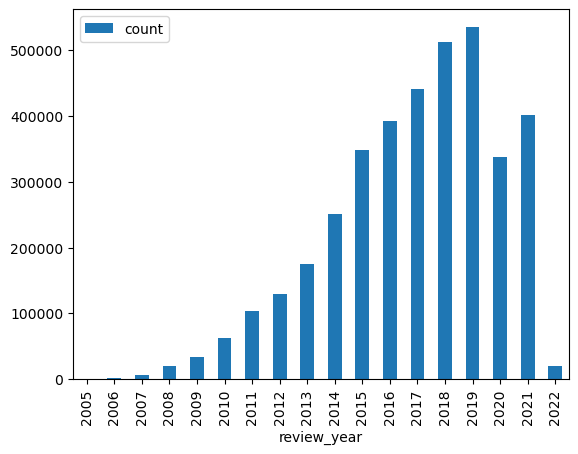

In [35]:
reviews_by_year_pd.set_index("review_year").plot(kind='bar')

**Distribution of Stars Using All Restaurant Reviews from Business Table**

In [36]:
stars_pd = df_business.groupBy("stars_business").count().orderBy("stars_business").toPandas()

In [37]:
stars_pd

,stars_business,count
0,1.0,189
1,1.5,1194
2,2.0,2160
3,2.5,3154
4,3.0,4569
5,3.5,7330
6,4.0,9183
7,4.5,6057
8,5.0,1151


<AxesSubplot:xlabel='stars_business'>

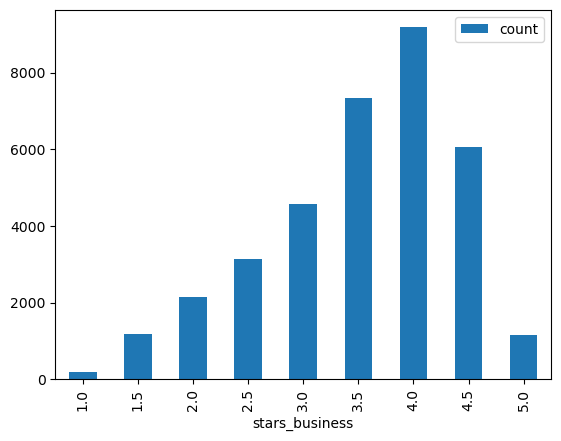

In [38]:
stars_pd.set_index("stars_business").plot(kind='bar')

**Distribution of Stars Using All Restaurant Reviews from Review Table**

In [39]:
stars_review_pd = df_review.groupBy("stars_review").count().orderBy("stars_review").toPandas()

In [40]:
stars_review_pd

,stars_review,count
0,1.0,444115
1,2.0,305725
2,3.0,416022
3,4.0,883270
4,5.0,1724638


<AxesSubplot:xlabel='stars_review'>

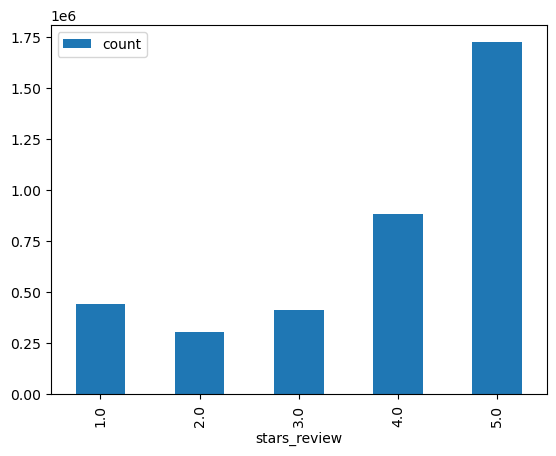

In [41]:
stars_review_pd.set_index("stars_review").plot(kind='bar')

**Distribution of Stars Using Useful Reviews from Review Table**

In [42]:
useful_reviews = df_review.filter(df_review["useful_review"] > 0)
stars_distribution_pd = useful_reviews.groupBy("stars_review").count().orderBy("stars_review").toPandas()

In [43]:
stars_distribution_pd

,stars_review,count
0,1.0,201741
1,2.0,142243
2,3.0,179843
3,4.0,381039
4,5.0,627352


<AxesSubplot:xlabel='stars_review'>

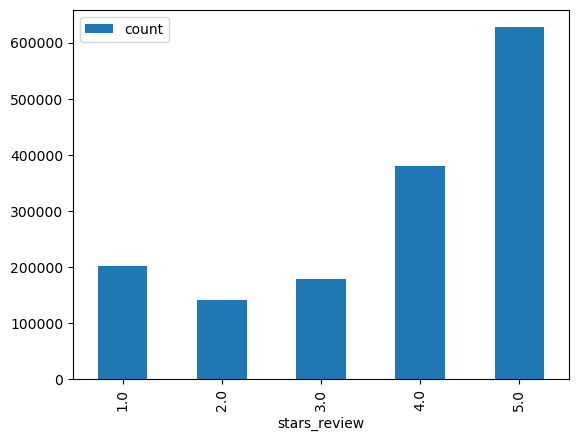

In [44]:
stars_distribution_pd.set_index("stars_review").plot(kind='bar')

**Does the Number of Year Someone has Been Yelp Elite Impact Ratings**

In [45]:
years_elite_pd = df_user.groupBy("years_elite").agg(avg("average_stars").alias("avg_stars")).orderBy("years_elite").toPandas()

In [46]:
years_elite_pd

,years_elite,avg_stars
0,1,3.692097
1,2,4.005818
2,3,4.010022
3,4,3.990812
4,5,3.959774
5,6,3.932801
6,7,3.912995
7,8,3.890329
8,9,3.850635
9,10,3.852228


<AxesSubplot:xlabel='years_elite'>

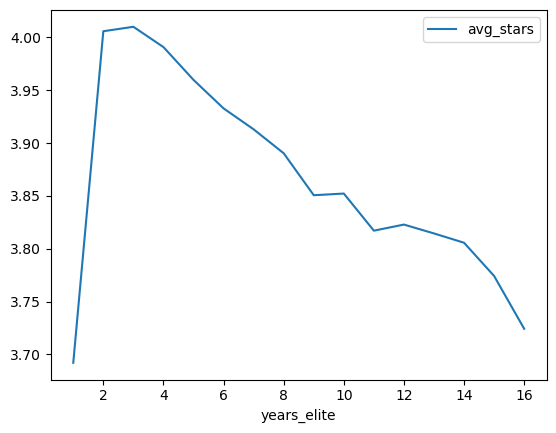

In [47]:
years_elite_pd.set_index("years_elite").plot(kind='line')

**Does Being Yelp Elite Impact Ratings**

In [48]:
is_elite_pd = df_user.groupBy("is_elite").agg(avg("average_stars").alias("avg_stars")).orderBy("is_elite").toPandas()

In [49]:
is_elite_pd

,is_elite,avg_stars
0,0,3.688616
1,1,3.980379


<AxesSubplot:xlabel='is_elite'>

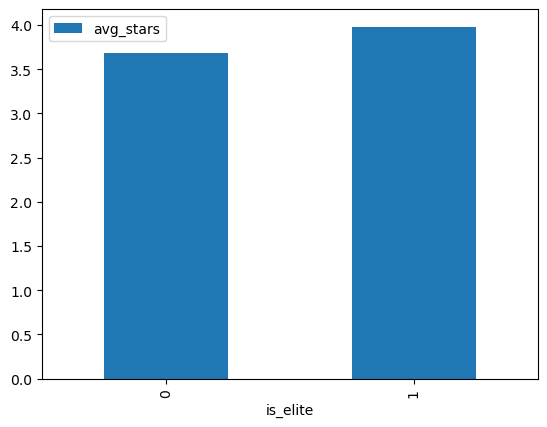

In [50]:
is_elite_pd.set_index("is_elite").plot(kind='bar')

**Correlation Between Yelp Elite and Ratings**

In [34]:
elite_review = df_user.join(df_review, df_user.user_id_u == df_review.user_id_r)

In [35]:
df_selected = elite_review.select('is_elite', 'stars_review')

In [ ]:
elite_review_pd = df_selected.toPandas()

In [37]:
correlation_matrix_elite_review = elite_review_pd.corr()

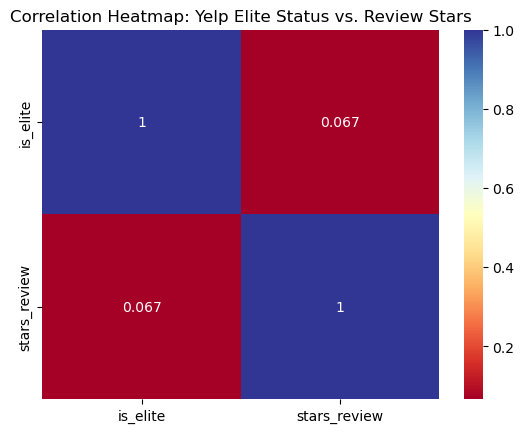

In [38]:
# Correlation heatmap
sns.heatmap(correlation_matrix_elite_review, annot=True, cmap="RdYlBu")
plt.title("Correlation Heatmap: Yelp Elite Status vs. Review Stars")
plt.show()

**Correlation Between Business Atributes and Ratings**

In [51]:
ambience_columns = [
    "Ambience_touristy", "Ambience_hipster", "Ambience_romantic",
    "Ambience_divey", "Ambience_intimate", "Ambience_trendy",
    "Ambience_upscale", "Ambience_classy", "Ambience_casual"
]
parking_columns = [
    "Parking_garage", "Parking_street", "Parking_validated",
    "Parking_lot", "Parking_valet"
]
good_for_meal_columns = [
    "GoodForMeal_brunch", "GoodForMeal_lunch", "GoodForMeal_dinner", 
    "GoodForMeal_latenight", "GoodForMeal_dessert"
]
other_features = [
    "Has_HappyHour", "Has_delivery", "Is_GoodForGroups", "Has_Free_Wifi"
]
columns_of_interest = ambience_columns + parking_columns + good_for_meal_columns + other_features + ["stars_business"]


In [52]:
df_selected = df_business.select(*columns_of_interest).toPandas()

In [53]:
correlation_matrix_biz_attributes = df_selected.corr()

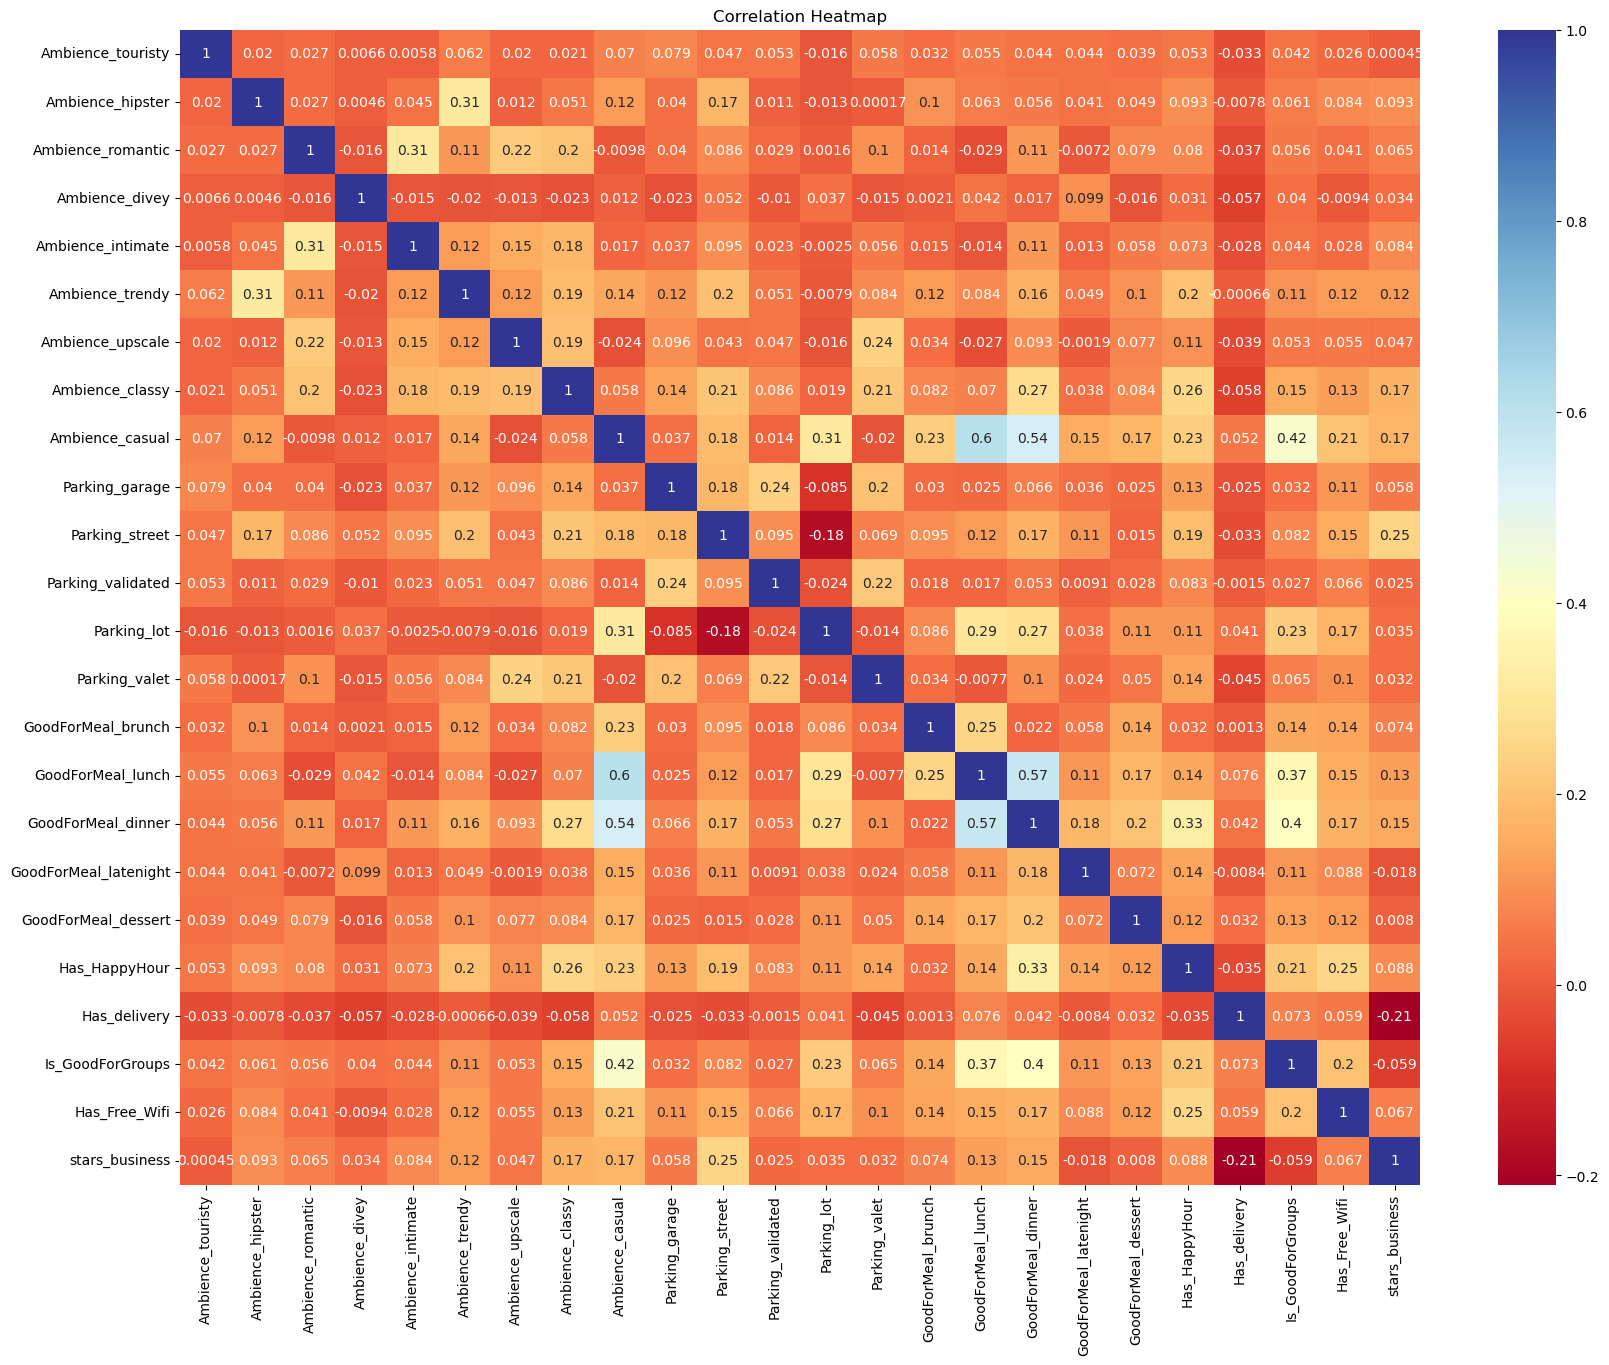

In [54]:
# Correlation heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix_biz_attributes, annot=True, cmap="RdYlBu")
plt.title("Correlation Heatmap")
plt.show()

In [55]:
correlation_matrix_biz_attributes['stars_business'].sort_values(ascending=False)

stars_business           1.000000
Parking_street           0.248382
Ambience_casual          0.168684
Ambience_classy          0.165451
GoodForMeal_dinner       0.148961
GoodForMeal_lunch        0.128287
Ambience_trendy          0.124013
Ambience_hipster         0.093136
Has_HappyHour            0.088223
Ambience_intimate        0.083565
GoodForMeal_brunch       0.073501
Has_Free_Wifi            0.066984
Ambience_romantic        0.065348
Parking_garage           0.058402
Ambience_upscale         0.047188
Parking_lot              0.035450
Ambience_divey           0.034288
Parking_valet            0.031869
Parking_validated        0.025437
GoodForMeal_dessert      0.007998
Ambience_touristy        0.000455
GoodForMeal_latenight   -0.018123
Is_GoodForGroups        -0.059042
Has_delivery            -0.209609
Name: stars_business, dtype: float64

**Does Having Wifi Impact Ratings**

In [56]:
wifi_pd = df_business.groupBy("Has_Free_Wifi").agg(avg("stars_business").alias("avg_stars")).orderBy("Has_Free_Wifi").toPandas()

<AxesSubplot:xlabel='Has_Free_Wifi'>

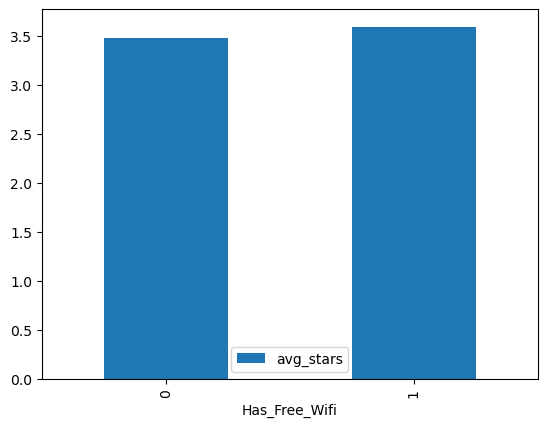

In [57]:
wifi_pd.set_index("Has_Free_Wifi").plot(kind='bar')

**Does Having Delivery Impact Ratings**

In [58]:
delivery_pd = df_business.groupBy("Has_delivery").agg(avg("stars_business").alias("avg_stars")).orderBy("Has_delivery").toPandas()

<AxesSubplot:xlabel='Has_delivery'>

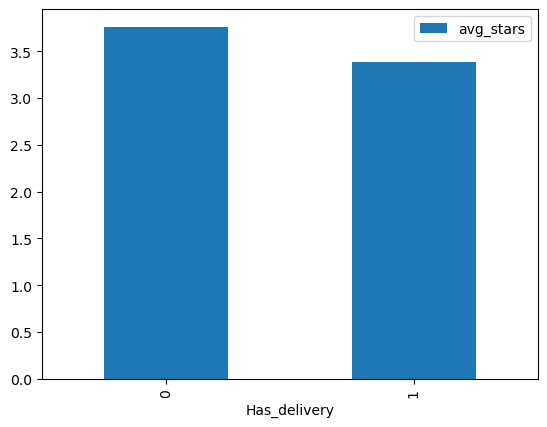

In [59]:
delivery_pd.set_index("Has_delivery").plot(kind='bar')

**Does Having Street Parking Impact Ratings**

In [60]:
parking_street_pd = df_business.groupBy("Parking_street").agg(avg("stars_business").alias("avg_stars")).orderBy("Parking_street").toPandas()

<AxesSubplot:xlabel='Parking_street'>

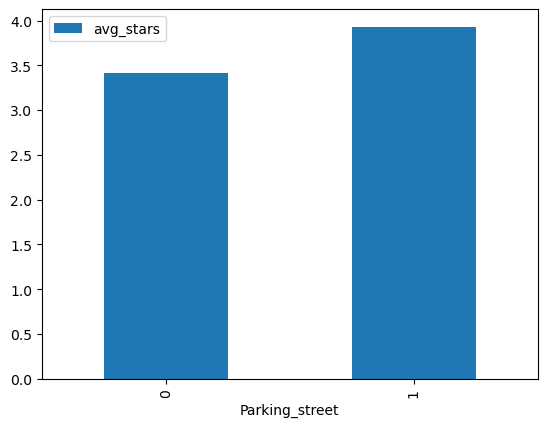

In [61]:
parking_street_pd.set_index("Parking_street").plot(kind='bar')

**Does Casual Ambiance Impact Ratings**

In [62]:
ambiance_casual_pd = df_business.groupBy("Ambience_casual").agg(avg("stars_business").alias("avg_stars")).orderBy("Ambience_casual").toPandas()

<AxesSubplot:xlabel='Ambience_casual'>

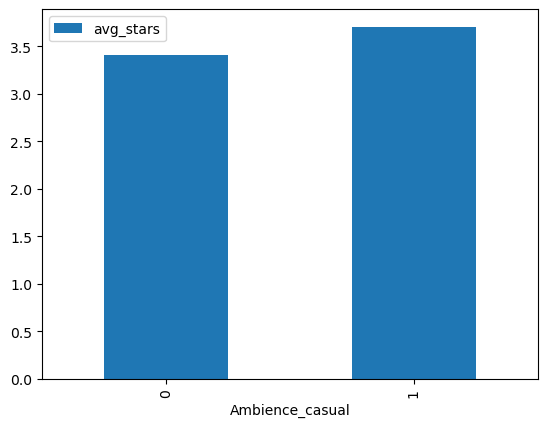

In [63]:
ambiance_casual_pd.set_index("Ambience_casual").plot(kind='bar')

**Does Classy Ambiance Impact Ratings**

In [64]:
ambiance_classy_pd = df_business.groupBy("Ambience_classy").agg(avg("stars_business").alias("avg_stars")).orderBy("Ambience_classy").toPandas()

<AxesSubplot:xlabel='Ambience_classy'>

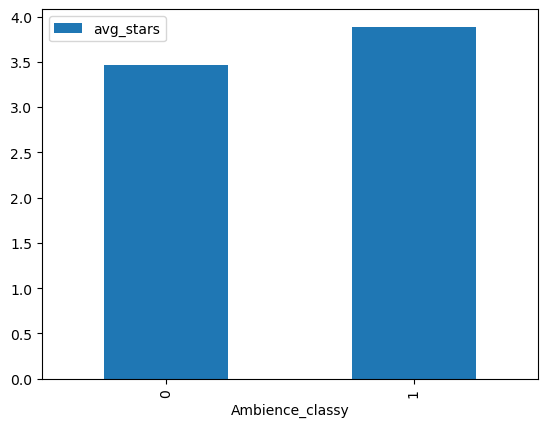

In [65]:
ambiance_classy_pd.set_index("Ambience_classy").plot(kind='bar')

**Correlation Between Sentiment Score and Ratings**

In [39]:
df_review_sentiment = df_sentiment.join(df_review, df_sentiment.review_id_s == df_review.review_id_r)

In [40]:
df_selected_sentiment = df_review_sentiment.select('Total_sentscore','Price_sentscore','Opinion_sentscore','Food_sentscore', 'Atmosphere_sentscore','Service_sentscore','Sentence_num', 'stars_review')

In [41]:
review_sentiment_pd = df_selected_sentiment.toPandas()

In [42]:
review_sentiment_pd

,Total_sentscore,Price_sentscore,Opinion_sentscore,Food_sentscore,Atmosphere_sentscore,Service_sentscore,Sentence_num,stars_review
0,-0.176471,0.058824,-0.176471,0.117647,-0.117647,0.058824,17,5.0
1,-0.312500,0.000000,-0.250000,-0.062500,0.000000,-0.125000,16,4.0
2,-1.000000,-0.666667,-0.333333,-0.333333,0.000000,0.000000,3,1.0
3,-0.777778,0.000000,-0.222222,0.000000,0.000000,-0.888889,9,2.0
4,0.058824,0.000000,-0.058824,0.058824,0.000000,0.058824,17,4.0
...,...,...,...,...,...,...,...,...
3773765,-0.500000,0.000000,0.000000,0.166667,-0.166667,-0.666667,12,1.0
3773766,-0.333333,0.000000,-0.200000,-0.133333,0.000000,0.000000,15,3.0
3773767,0.666667,0.000000,0.333333,0.000000,0.666667,0.000000,3,5.0
3773768,-0.875000,0.000000,0.000000,-0.562500,-0.062500,-0.500000,16,2.0


In [43]:
# To calculate correlation matrix
correlation_matrix_review_sentiment = review_sentiment_pd.corr()

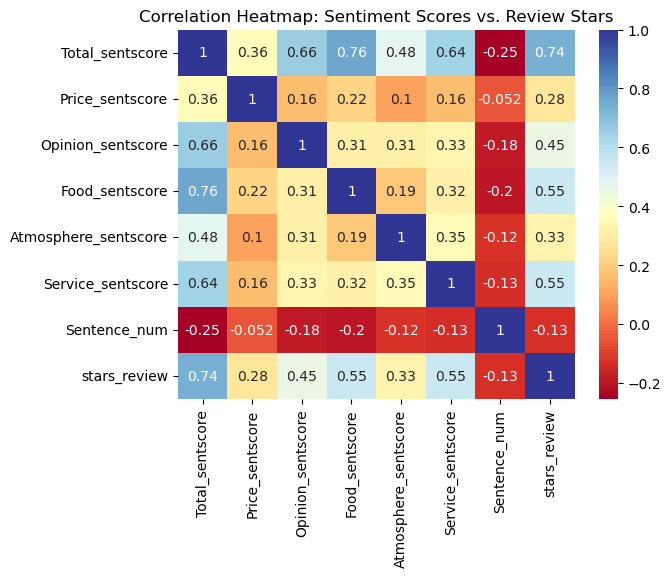

In [44]:
# Correlation heatmap
sns.heatmap(correlation_matrix_review_sentiment, annot=True, cmap="RdYlBu")
plt.title("Correlation Heatmap: Sentiment Scores vs. Review Stars")
plt.show()

In [45]:
correlation_matrix_review_sentiment['stars_review'].sort_values(ascending=False)

stars_review            1.000000
Total_sentscore         0.736766
Service_sentscore       0.552603
Food_sentscore          0.550875
Opinion_sentscore       0.452347
Atmosphere_sentscore    0.326085
Price_sentscore         0.279498
Sentence_num           -0.128935
Name: stars_review, dtype: float64

**Correlation Between Total Score and Ratings**

In [52]:
df_selected_total_sentiment = df_review_sentiment.select('Price_total','Opinion_total','Food_total','Atmosphere_total','Service_total', 'stars_review')

In [53]:
review_total_sentiment_pd = df_selected_total_sentiment.toPandas()

In [54]:
review_total_sentiment_pd

,Price_total,Opinion_total,Food_total,Atmosphere_total,Service_total,stars_review
0,0,1,2,0,1,3.0
1,1,6,6,3,3,5.0
2,0,7,5,7,4,4.0
3,2,1,1,0,0,1.0
4,1,0,1,0,0,5.0
...,...,...,...,...,...,...
3773765,0,1,1,1,0,4.0
3773766,0,3,7,1,1,1.0
3773767,0,1,2,1,0,5.0
3773768,2,6,13,6,5,4.0


In [55]:
# To calculate correlation matrix
correlation_matrix_review_toal_sentiment = review_total_sentiment_pd.corr()

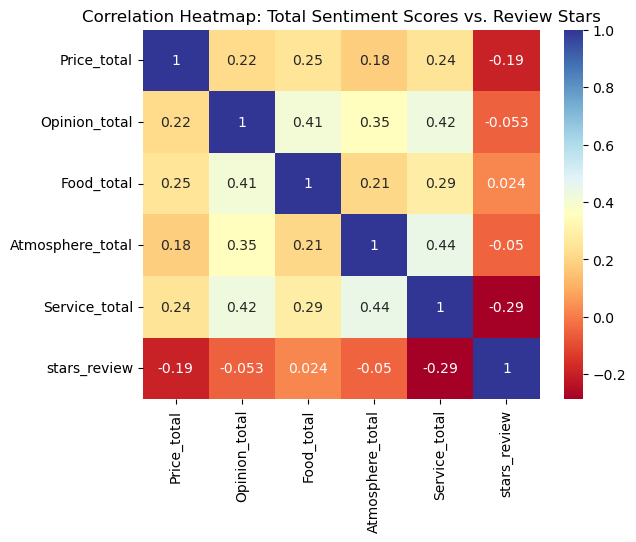

In [56]:
# Correlation heatmap
sns.heatmap(correlation_matrix_review_toal_sentiment, annot=True, cmap="RdYlBu")
plt.title("Correlation Heatmap: Total Sentiment Scores vs. Review Stars")
plt.show()

In [57]:
correlation_matrix_review_toal_sentiment['stars_review'].sort_values(ascending=False)

stars_review        1.000000
Food_total          0.023970
Atmosphere_total   -0.049952
Opinion_total      -0.052568
Price_total        -0.191853
Service_total      -0.287202
Name: stars_review, dtype: float64

**Interactive Map of Top 100 Restaurants in Tucson, AZ**

In [58]:
import folium

In [59]:
# Filter and sort the DataFrame to get top-rated restaurants in Tucson, Arizona
df_top_restaurants = df_business.filter((df_business.city == "Tucson") & (df_business.state == "AZ")) \
    .orderBy(df_business.stars_business.desc()) \
    .select("latitude", "longitude", "name", "stars_business") \
    .limit(100)

In [60]:
# Create a Folium map centered around Tucson, Arizona
map_tucson = folium.Map(location=[32.2226, -110.9747], zoom_start=12)

In [61]:
# Add markers for each top-rated restaurant
for row in df_top_restaurants.collect():
    lat, lon, name, rating = row
    popup_text = f"<b>Restaurant:</b>{name}<br><b>Rating:</b> {rating}"
    folium.Marker(location=[lat, lon], popup=popup_text).add_to(map_tucson)

In [62]:
# Display the map
map_tucson